In [1]:
import gmsh

In [2]:
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from sympy import solve, symbols
from math import pi, sin, cos
import numpy as np

In [3]:
gmsh.initialize()
gmsh.model.add("horn-curve")

In [4]:
r = 1
a = 1/15
b = 3/10
R = 2
t = a/2

freq=1000
c_air=340
l=c_air/freq
lc=l/12

In [5]:
def vector_angle(v1, v2):
    uv1 = np.divide(v1, np.linalg.norm(v1))
    uv2 = np.divide(v2, np.linalg.norm(v2))
    return np.arccos(np.dot(uv1, uv2))

def compute_points(a, b, r, R):
    x = symbols('x')
    y = symbols('y')
    eqs = [
        x**2+(y-b)**2-R**2,
        (x+r)**2+(y-a)**2-R**2
    ]
    s = solve(eqs, [x,y])
    # print(s)
    x0, y0 = float(s[0][0]), float(s[0][1])

    theta = vector_angle([-r-x0, a-y0], [-x0, b-y0])
    y = 3*pi/2-vector_angle([0, -1], [-r-x0, a-y0])

    #print(
    #    x0+(R-t)*math.cos(y),       y0+(R-t)*math.sin(y),
    #    x0+(R  )*math.cos(y),       y0+(R  )*math.sin(y),
    #    x0+(R-t)*math.cos(y+theta), y0+(R-t)*math.sin(y+theta),
    #    x0+(R  )*math.cos(y+theta), y0+(R  )*math.sin(y+theta)
    #)
    
    points = [
        (0, 0),                                           # 1 center
        (x0, y0),                                         # 2 horn center
        (-r,0),                                           # 3 left corner
        (x0+(R  )*cos(y),       y0+(R  )*sin(y)),         # 4 annulus
        (x0+(R  )*cos(y+theta), y0+(R  )*sin(y+theta)),   # 5
        (x0+(R-t)*cos(y+theta), y0+(R-t)*sin(y+theta)),   # 6
        (x0+(R-t)*cos(y),       y0+(R-t)*sin(y)),         # 7
        (r,0),                                            # 8 right corner
    ]
    # print(points)
    return points

In [6]:
points = compute_points(a,b,r,R)
g_points = []
for p in points:
    g_points.append(gmsh.model.geo.addPoint(p[0], p[1], 0, lc))

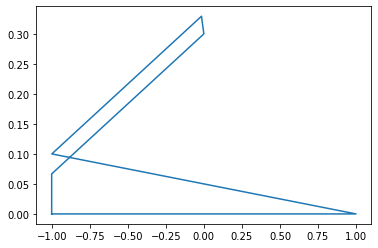

In [7]:
p_points_x = []
p_points_y = []

def add_points(pi):
    p_points_x.append(points[pi-1][0])
    p_points_y.append(points[pi-1][1])
    
add_points(3)
add_points(4)
add_points(5)
add_points(6)
add_points(7)
add_points(8)
add_points(3)

plt.plot(p_points_x, p_points_y)

In [8]:
s1 = gmsh.model.geo.addLine(3, 4)
s2 = gmsh.model.geo.addCircleArc(4, 2, 5)
s3 = gmsh.model.geo.addLine(5, 6)
s4 = gmsh.model.geo.addCircleArc(6, 2, 7)
s5 = gmsh.model.geo.addCircleArc(7, 1, 8)
s6 = gmsh.model.geo.addLine(8, 3)

In [9]:
g_border    = gmsh.model.geo.addCurveLoop([s1,s2,s3, s4, s5, s6])
g_dirichlet = gmsh.model.geo.addCurveLoop([s1])
g_neumann   = gmsh.model.geo.addCurveLoop([s5])
g_symm      = gmsh.model.geo.addCurveLoop([s6])
g_hard      = gmsh.model.geo.addCurveLoop([s2, s3, s4])

g_surface   = gmsh.model.geo.addPlaneSurface([g_border])

gmsh.model.geo.synchronize()

pm_surface = 1
gmsh.model.addPhysicalGroup(dim=2, tags=[g_surface], tag=pm_surface)
gmsh.model.setPhysicalName(dim=2, tag=pm_surface, name="Horn 2D")

pm_dirichlet = 2
gmsh.model.addPhysicalGroup(dim=1, tags=[g_dirichlet], tag=pm_dirichlet)
gmsh.model.setPhysicalName(dim=1, tag=pm_dirichlet, name="Boundary Dirichlet")

pm_neumann = 3
gmsh.model.addPhysicalGroup(dim=1, tags=[g_neumann], tag=pm_neumann)
gmsh.model.setPhysicalName(dim=1, tag=pm_neumann, name="Boundary Neumann")


gmsh.model.mesh.generate(3)
gmsh.write("horn.msh")









Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Circle)
Info    : [ 70%] Meshing curve 5 (Circle)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.0005787s, CPU 0.001164s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0497065s, CPU 0.050125s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 1.0484e-05s, CPU 1.1e-05s)
Info    : 2753 nodes 5508 elements
Info    : Writing 'horn.msh'...
Info    : Done writing 'horn.msh'


In [10]:
from firedrake import *
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

mesh = Mesh('horn.msh')


/home/pierre/src/firedrake/src/firedrake/firedrake/randomfunctiongen.py:358: UserWarning: Found unknown attribute: Falling back to numpy.random.PCG64DXSM, but Firedrake might need to wrap this attribute.
  warnings.warn("Found unknown attribute: Falling back to numpy.random.%s, but Firedrake might need to wrap this attribute." % module_attr)


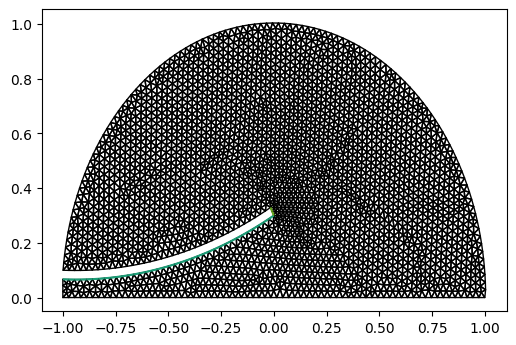

In [11]:
triplot(mesh)